In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline

import pandas as pd

### Create sum of normals data

In [3]:
## Loop. Create I cases of the observed totals of the q quantiles.

I = 1000
T = 16

df_q_list = []
for Q in [10, 15, 20]:
    x = np.arange(0, 1, 1/Q) + .5/Q
    v = 1.5 - x
    for q in range(Q):
        block_q = np.random.normal(0, v[q], (I, T)) # generate data (*)
        df_q = pd.DataFrame(block_q) # as dataframe
        # add indexer columns
        df_q['q'] = q
        df_q['Q'] = Q
        df_q = df_q.reset_index().rename(columns = {'index': 'i'})
        df_q = df_q.set_index(['Q', 'q', 'i'])
        df_q_list += [df_q]
        
df = pd.concat(df_q_list)

# (*) In the real case, these rows will not just be a gaussian but the sum of powers.
# This is interesting per se and there are results to obtain here. 

# Using size dist and growth rates we can have nice estimations of std vs quantile.

# The colored bands I have from before are based on the real size dists. 
# They have the kind of problem that apparently there can be aggregate shocks, 
# or some baseline that will not be fully subtracted, 
# so that in large numbers volatility goes down to this base level.


In [4]:
# I = 500. T = 16
# the block is I x T
# It has some random or gaussian values.
# Actually it should be the logdiff.
# This log comes from the sum, ie. size dist plus growth rates.
# block_q

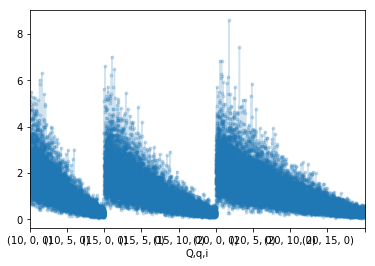

In [5]:
# Ok, now we have a dataset with generated random values for the quantiles, in many possible draws.
# It is indexed by Q, q, i and each line is a simultaion of the values of such quantile in linear scale.

# We can add a column with the variance of each row. 
df['var_qi'] = df.var(1)
df.var(1).plot(marker = '.', alpha = .2)


In [6]:
# If we test the Taylor expansion estimator on the simple sum of gaussians case, we should get coefficients of 1. 
# It is a test bed...

In [8]:
## Import 
df = pd.read_csv('./../../data/processed/exp_var_lapl_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()
# df = pd.read_csv('./../../data/processed/exp_var_norm_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()
# df = pd.read_csv('./../../data/processed/exp_var_sbtn_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()

In [9]:
# Median blocks.
df['dev_median'] = df.groupby(level=[0,1]).apply(lambda x: abs(x - x.median()))['var_qi']#.plot(marker = '.')
df_median_pool = df.groupby(level=[0,1]).apply(lambda x: x.nsmallest(3, 'dev_median').reset_index(drop = True))

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Taylor estimator.

# access blocks from the df.

Q_ = 25 #10, 15
df_Q = df.loc[Q_]
df_mp_Q = df_median_pool.loc[Q_]
df_xy_list = []

for q in range(Q_):
    print(q)
    df_q = df_Q.loc[q]

    # Option 1. Sample median blocks only once. Shuffling of other blocks will not introduce noise.
    df_median_m = df_mp_Q.groupby(level=[0]).apply(lambda x: x.sample(1).reset_index(drop = True))
    
    df_q_part = df_q
    var_i_list = []
    for i, row in df_q_part.iterrows(): # not necessary to have all I's.
    # Option 2. Sample median each time. Incorporate uncertainty of other blocks. #TOO NOISY
#         df_median_m = df_mp_Q.groupby(level=[0]).apply(lambda x: x.sample(1).reset_index(drop = True))
    # (we want to avoid a fixed 'angle' of the vector with the 16 levels of the rest of the qs. 
    # As it will deform the outcome of sigma_qi's in a determined way)
    
        # Insert the i row in place of the median for q.
        dfm = df_median_m
        df_i = df_median_m.copy()
        row = pd.DataFrame(row).T
        row.index = pd.MultiIndex.from_product([[q], row.index])
        df_i = df_i.drop(q).append(row)
        
        # Do the total, get it's var. this is 'y'. store
#         var_i = df_i[range(T)].sum().var()
        var_i = np.log10(df_i.iloc[:, :T].sum()).var() # we possibly want the var of logs.
        var_i_list += [var_i]
    df_xy = df_q_part[['var_qi']]
    df_xy['y'] = np.array(var_i_list)
    df_xy['q'] = q
    
    df_xy_list += [df_xy]
    
df_xy = pd.concat(df_xy_list)
# The 'x' are the sigma i. They are already in df.

# I have an x, y. Store it.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


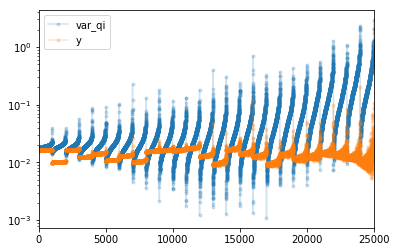

In [22]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

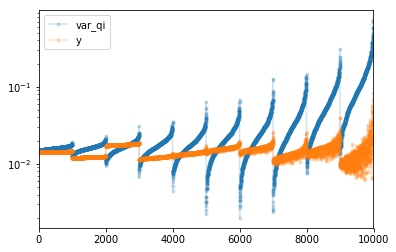

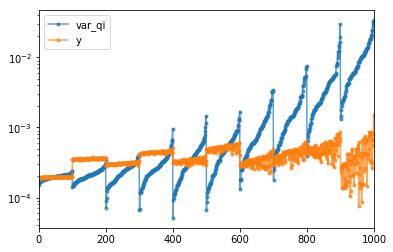

In [232]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

In [ ]:
# For all the variables, get the x y's.
# fit poly, get coefficients, store. 
# option to plot.

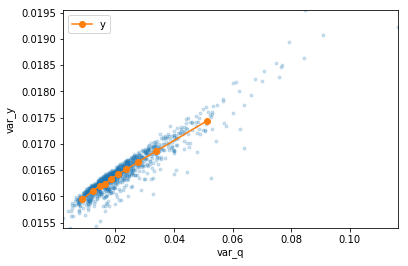

In [84]:
fits = []
for q in range(Q_)[:10]:
    df_xy_q = df_xy.loc[df_xy.q == q]
    # points
    x = df_xy_q.var_qi
    y = df_xy_q.y
    # fit
    z = np.polyfit(x, y, 1)
    fits += [z]
fits = np.array(fits)

fig, ax = plt.subplots(1)
ax.plot(df_xy_q.var_qi, df_xy_q.y, '.', alpha = .2)
bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)
#     ax.set_xlim(0, .1)
#     ax.set_ylim(0.01, 0.03)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.set_xlabel('var_q') 
ax.set_ylabel('var_y')
plt.show()
# Laplace

In [53]:
def parabola(x, a, b, c):
    return a * x**2 + b * x + c

partial_devs_2 = np.array([parabola(np.median(x), *pars) for pars in fits])

In [65]:
def linear(x, a, b):
    return a * x + b

partial_devs_1 = np.array([linear(np.median(x), *pars) for pars in fits])

(0, 0.05)

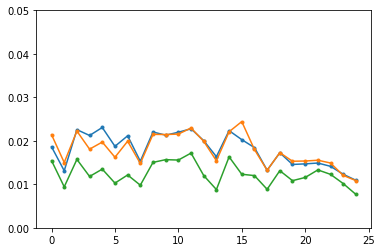

In [68]:

plt.plot(range(Q_), partial_devs, marker = '.')
plt.plot(range(Q_), partial_devs_1, marker = '.')
# plt.plot(range(Q_), fits[:, 0], marker = '.')
plt.plot(range(Q_), fits[:, 1], marker = '.')
plt.ylim(0, .05)

In [62]:
fits

array([[0.03620601, 0.01544672],
       [0.03389804, 0.00941662],
       [0.03944386, 0.01572583],
       [0.03806926, 0.01180555],
       [0.03772671, 0.01349247],
       [0.03604369, 0.01027717],
       [0.04704222, 0.01214876],
       [0.03037466, 0.0097978 ],
       [0.03907632, 0.01504231],
       [0.03503717, 0.0156699 ],
       [0.03620065, 0.0155789 ],
       [0.03501987, 0.01718015],
       [0.04769759, 0.01201752],
       [0.04018787, 0.00879291],
       [0.03501285, 0.01631222],
       [0.07341715, 0.01231351],
       [0.03638931, 0.01200372],
       [0.02646116, 0.00885485],
       [0.02516168, 0.01313659],
       [0.02705267, 0.01084104],
       [0.02293565, 0.01157342],
       [0.01350947, 0.01331026],
       [0.0158052 , 0.01228837],
       [0.01139412, 0.01016846],
       [0.01922569, 0.00767961]])

In [245]:
# Gaussian

[0.0863967  0.01296385]
[0.08842814 0.01074267]
[0.09689284 0.01611861]
[0.08432123 0.01063715]
[0.08689185 0.01206402]
[0.09146881 0.01389333]
[0.08071326 0.01385786]
[0.07617694 0.01076438]
[0.04747966 0.01308357]
[0.05237573 0.00767953]


[0.98859968 6.31536187]
[1.0726746  5.50727238]
[1.16982095 8.42172979]
[1.14772977 7.27886601]
[0.99899666 8.59448406]
[ 1.11401587 15.97862462]
[1.3146688  9.78260646]
[1.07650366 8.68275585]
[ 1.18007377 12.5288997 ]
[ 1.09623537 11.0625377 ]


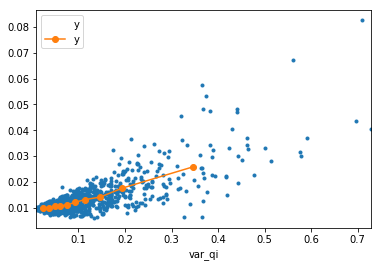

In [252]:
fig, ax = plt.subplots(1)

df_xy_q.plot('var_qi', 'y', marker = '.', lw = 0, ax = ax)
bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

## Test at sigma = 0
What if the sigma_0 point is set at zero? what are the dependencies? 

What happens with Q and the total? The curvature of the log should have an effect

In [151]:
tot_size = 1e11
M = 50000

result_list = []
for Q in [2, 3, 4, 5, 7, 10, 15, 20, 25, 30]:
    v = []
    for var in np.arange(0, 0.005, 0.0001):
        q_size = np.log10(tot_size/Q)
#         sim_q_size_lin = np.power(10, q_size + np.random.laplace(0, np.sqrt(var), M)/np.sqrt(2))
        sim_q_size_lin = np.power(10, q_size + np.random.normal(0, np.sqrt(var), M))
        sim_log_totals = np.log10(sim_q_size_lin + (1 - 1/Q)*tot_size)
        v += [[var, sim_log_totals.var()]]

    result = pd.DataFrame(np.array(v), columns = ['var_q', 'var'])
    result['Q'] = Q
    result_list += [result]
    
result = pd.concat(result_list)

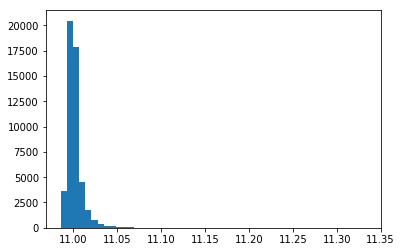

In [136]:
plt.hist(sim_log_totals, 50)
plt.show()

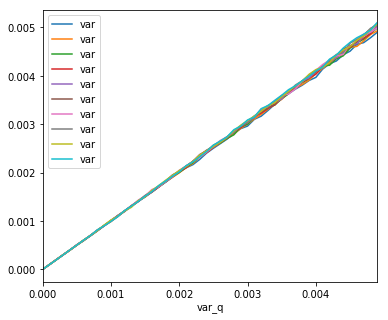

In [161]:
fig, ax = plt.subplots(1, figsize = (6, 5))

for Q in result.Q.unique()[:10]:
    slice_ = result.loc[result.Q == Q]
    slice_['var'] = Q**2*slice_['var']
    slice_.plot('var_q', 'var', ax = ax)

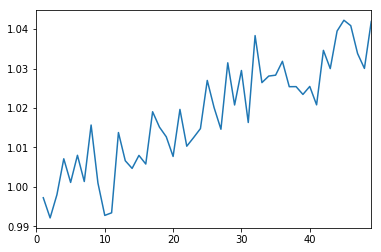

In [162]:
(slice_['var']/slice_['var_q']).plot()